## SIT-789 Task-9.2C

## Section-1

In [1]:
import numpy as np
import librosa
from pydub import AudioSegment
from pydub.utils import mediainfo
from sklearn import preprocessing

c:\program files\python37\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
def mfcc_extraction(audio_filename, #.wav filename
                    hop_duration, #hop_length in seconds, e.g., 0.015s (i.e., 15ms)
                    num_mfcc #number of mfcc features
                   ):
    speech = AudioSegment.from_wav(audio_filename) #Read audio data from file
    samples = speech.get_array_of_samples() #samples x(t)
    sampling_rate = speech.frame_rate #sampling rate f
    mfcc = librosa.feature.mfcc(
        np.float32(samples),
        sr = sampling_rate,
        hop_length = int(sampling_rate * hop_duration),
        n_mfcc = num_mfcc)
    return mfcc.T

In [3]:
from sklearn.mixture import GaussianMixture
def learningGMM(features, #list of feature vectors, each feature vector is an array
                n_components, #the number of components
                max_iter #maximum number of iterations
               ):
    
    gmm = GaussianMixture(n_components = n_components, max_iter = max_iter)
    gmm.fit(features)
    return gmm

In [4]:
import os
path = 'SpeakerData/'
speakers = os.listdir(path + 'Train/')
print(speakers)

['Anthony', 'AppleEater', 'Ara', 'Argail', 'Ariyan', 'Arjuan', 'Artem', 'Arthur', 'Artk', 'Arun', 'Arvala', 'Asalkeld', 'Asladic', 'Asp', 'Azmisov', 'B', 'Bachroxx', 'Bae', 'Bahoke', 'Bareford', 'Bart', 'Bassel', 'Beady', 'Beez', 'BelmontGuy']


In [5]:
from sklearn import preprocessing

#this list is used to store the MFCC features of all training data of all speakers
mfcc_all_speakers = []
hop_duration = 0.015 #15ms
num_mfcc = 12
for s in speakers:
    sub_path = path + 'Train/' + s + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    mfcc_one_speaker = np.asarray(())
    for fn in sub_file_names:
        mfcc_one_file = mfcc_extraction(fn, hop_duration, num_mfcc)
        if mfcc_one_speaker.size == 0:
            mfcc_one_speaker = mfcc_one_file
        else:
            mfcc_one_speaker = np.vstack((mfcc_one_speaker, mfcc_one_file))
    mfcc_all_speakers.append(mfcc_one_speaker)

In [7]:
import pickle
for i in range(0, len(speakers)):
    with open('TrainingFeatures/' + speakers[i] + '_mfcc.fea','wb') as f:
        pickle.dump(mfcc_all_speakers[i], f)

In [8]:
n_components = 5
max_iter = 50
gmms = [] #list of GMMs, each is for a speaker

for i in range(0, len(speakers)):
    gmm = learningGMM(mfcc_all_speakers[i],
                      n_components,
                      max_iter)
    gmms.append(gmm)

In [9]:
for i in range(len(speakers)):
    with open('Models/' + speakers[i] + '.gmm', 'wb') as f: #'wb' is for binary write
        pickle.dump(gmms[i], f)

## Section-2

In [10]:
gmms = []
for i in range(len(speakers)):
    with open('Models/' + speakers[i] + '.gmm', 'rb') as f: #'wb' is for binary write
        gmm = pickle.load(f)
        gmms.append(gmm)

In [19]:
def speaker_recognition(audio_file_name, gmms):
    speaker_id = 0 #you need to calculate this
    mfcc = mfcc_extraction(audio_file_name, 0.015, 12)
    scores = []
    for i in range(0, len(gmms)):
        scores.append(gmms[i].score(mfcc))
        
    speaker_id = scores.index(max(scores))
    return speaker_id

In [20]:
speaker_id = speaker_recognition('SpeakerData/Test/Ara/a0522.wav', gmms)
print(speakers[speaker_id])

Ara


In [21]:
test_file_names = []
test_speaker_labels = []

for i in range(0, len(speakers)):
    sub_path = path + 'Test/' + speakers[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_speaker_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    test_file_names += sub_file_names
    test_speaker_labels += sub_speaker_labels

In [24]:
def get_predicted_labels(gmms):
    predicted_speaker_labels = []
    for file_name in test_file_names:
        predicted_speaker_label = speaker_recognition(file_name, gmms)
        predicted_speaker_labels.append(predicted_speaker_label)
    return predicted_speaker_labels

In [39]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
def get_classification_report(predicted_speaker_labels):    
    cm = confusion_matrix(test_speaker_labels, predicted_speaker_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm.diagonal())
    print(classification_report(test_speaker_labels, predicted_speaker_labels))
    print('Accuracy Score', accuracy_score(test_speaker_labels, predicted_speaker_labels))
    return cm

In [40]:
predicted_speaker_labels = get_predicted_labels(gmms)
cm = get_classification_report(predicted_speaker_labels)

[0.14285714 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.85714286 1.         0.57142857 1.         1.         1.
 1.        ]
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         7
           7       0.44      1.00      0.61         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00     

<AxesSubplot:>

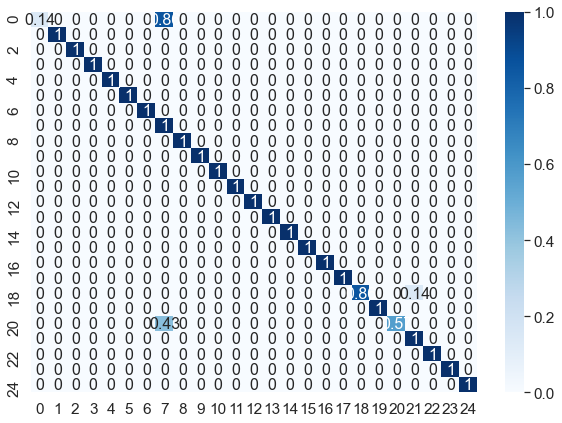

In [41]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size